In [1]:
# For changing directories to C++ programming and runnning files
import subprocess as sp
import os

# since using WSL2
os.environ['MPLCONFIGDIR'] = '/tmp/'

# Typical functionality for data manipulation and generation of latin hypercube
import numpy as np
from pyDOE import lhs

# Gaussian Process emulator 
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

# for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
# import seaborn as sns
# sns.set("notebook")
%matplotlib inline
plt.style.use('default')


In [12]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
# My costumizations for plots
import matplotlib.font_manager
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Computer Modern Roman']})
rc('text', usetex=True)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def costumize_axis(ax, x_title, y_title):
    ax.set_xlabel(x_title, fontsize=24)
    ax.set_ylabel(y_title, fontsize=24)
    ax.tick_params(axis='both', labelsize=18, top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=8)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis='both', which='minor', direction='in', length=4, top=True, right=True)
    return ax

In [3]:
# Others costumizations for plots
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('white')
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    costumize_axis(ax1, '', '')
    costumize_axis(ax2, '', '')
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y, color='blue')
    ax1.hist(X, color='blue', density=True)
    ax2.hist(Y, color='blue', orientation='horizontal', density=True)
    costumize_axis(ax, nameX, nameY)

In [4]:
def PrintParametersFile(params_dict):
    '''
    Function ouputs file "params.txt" to the Code/util folder to be used by the
    Code/build/exact_solution.x program
    '''
    os.chdir('/mnt/c/users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/')
    with open('./utils/params.txt', 'w') as fout:
        fout.write(f'tau_0 {params_dict["tau_0"]}\n')
        fout.write(f'Lambda_0 {params_dict["Lambda_0"]}\n')
        fout.write(f'alpha_0 {params_dict["alpha_0"]}\n')
        fout.write(f'xi_0 {params_dict["xi_0"]}\n')
        fout.write(f'ul {params_dict["tau_f"]}\n')
        fout.write(f'll {params_dict["tau_0"]}\n')
        fout.write(f'mass {params_dict["mass"]}\n')
        fout.write(f'eta_s {params_dict["eta_s"]}\n')
        fout.write(f'pl0 {params_dict["pl0"]}\n')
        fout.write(f'pt0 {params_dict["pt0"]}\n')
        fout.write(f'TYPE {params_dict["hydro_type"]}')
    os.chdir('/mnt/c/users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/scripts/')
    return 

def RunHydroSimulation():
    '''
    Function calls the C++ excecutable that run hydro calculations
    '''
    os.chdir('/mnt/c/users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/')
    sp.run(['./build/exact_solution.x'], shell=True)
    os.chdir('/mnt/c/users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/scripts/')
    return

In [5]:
# Need to define latin hypercube sampling points and then run hydrodynamic simulation for all.
num_parameters_in_GP = 2 # Should be minimum of two to take into account relaxation time constant and ending time
GP_parameter_names = ['eta_s', 'tau_f'] # Expand as needed
# Make sure that order of ranges variable matches how they appear in names_of_GP_parameters
GP_parameter_ranges = np.array([[1 / (4 * np.pi), 10 / (4 * np.pi)], [10, 20]])
num_design_points = 20 * num_parameters_in_GP
unit = lhs(n=num_parameters_in_GP, samples=num_design_points, criterion='maximin')
GP_design_points = GP_parameter_ranges[:, 0] + unit * (GP_parameter_ranges[:, 1] - GP_parameter_ranges[:, 0])
GP_design_range = GP_parameter_ranges[:,1] - GP_parameter_ranges[:,0]
print(GP_design_range)

[ 0.71619724 10.        ]


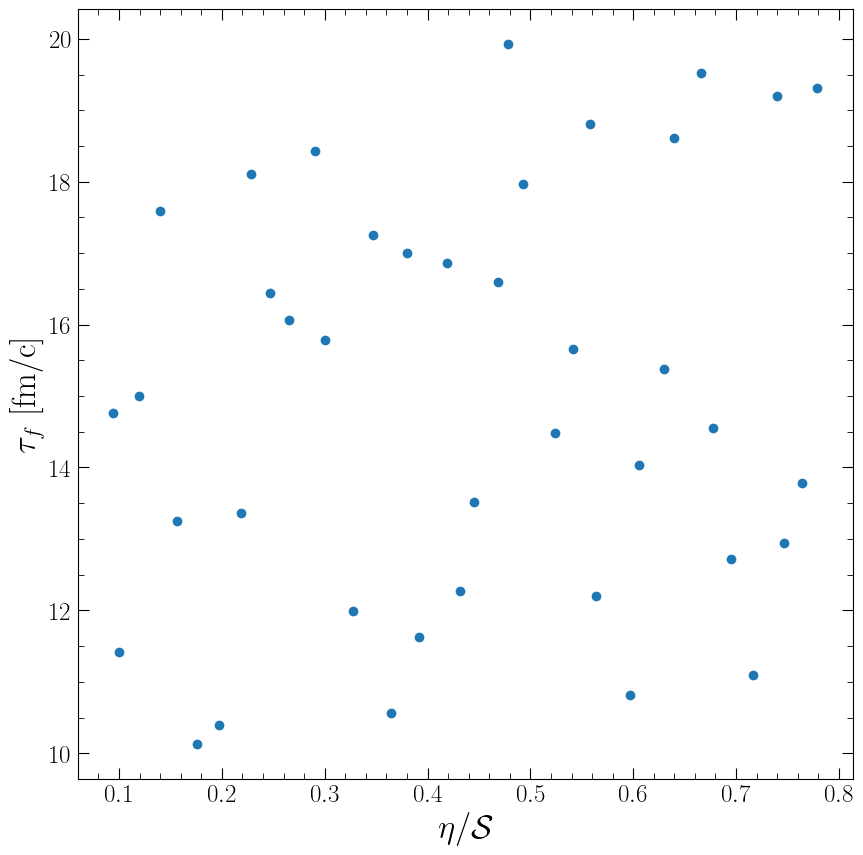

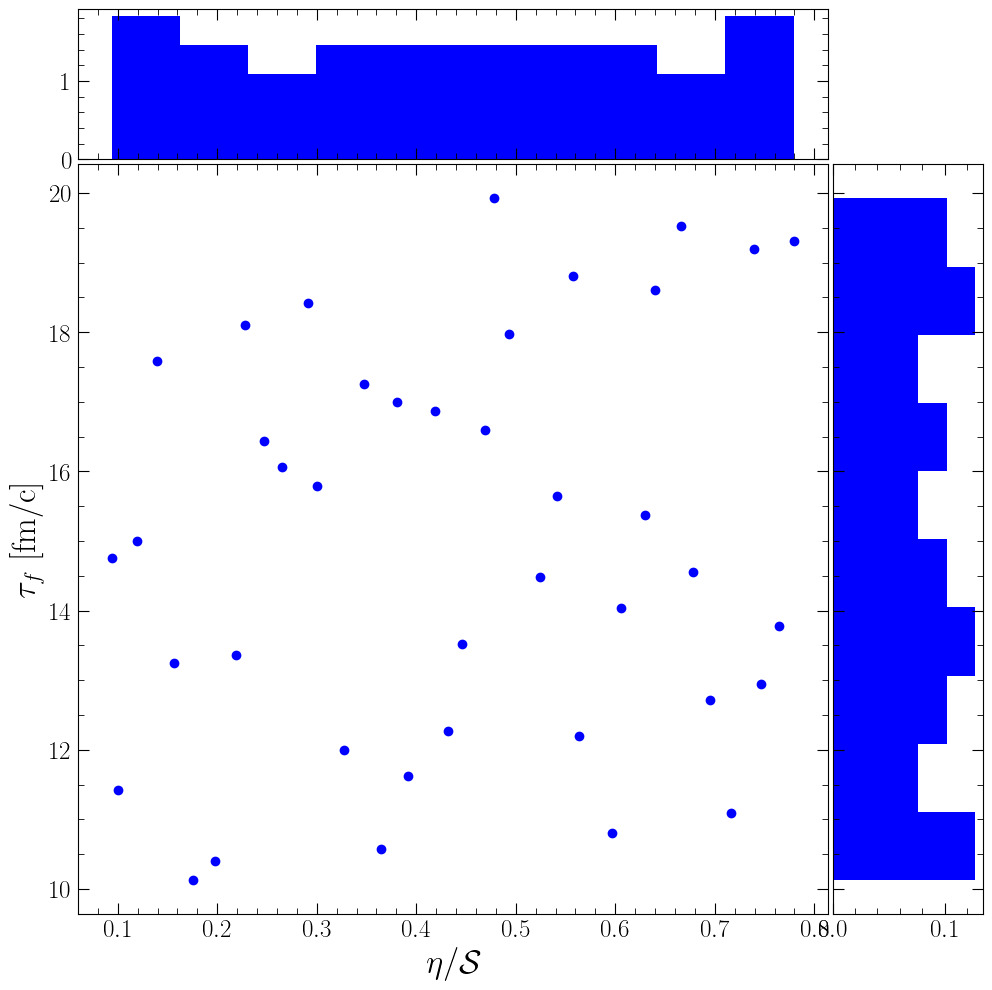

In [6]:
# fig, ax = plt.subplots(figsize=(10, 10))
# fig.patch.set_facecolor('white')
# ax.scatter(GP_design_points[:, 0], GP_design_points[:, 1])
# costumize_axis(ax, r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')

hist_1d_2d(GP_design_points[:, 0], GP_design_points[:, 1], r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')

In [7]:
#default values for parameters
params = {
    'tau_0': 0.1,
    'Lambda_0': 1.647204044,
    'xi_0': -0.8320365099,
    'alpha_0': 0.654868759,
    'tau_f': 100.1,
    'mass': 1.015228426,
    'eta_s': 0.23873241463784,
    'pl0': 8.1705525351457684,
    'pt0': 1.9875332965147663,
    'hydro_type': 0
}

In [8]:
# function run runs hydro code to generate simualtion results for a set of 
# given parameters
def ProcessHydro(parameter_names, simulation_points):
    out_list = []
    def GetFromOutputFiles(hydro_type):
        if hydro_type == 0:
            prefix = '../output/CE_hydro/'
            suffix = ''
        elif hydro_type == 1:
            prefix = '../output/DNMR_hydro/'
            suffix = ''
        elif hydro_type == 2:
            prefix = '../output/aniso_hydro/'
            suffix = ''
        else:
            prefix = '../output/aniso_hydro/'
            suffix = '2'
         
        f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r')
        last_e = f_e.readlines()[-1]
        tau, e = last_e.split()[0], last_e.split()[1]
        f_e.close(); del last_e

        f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r')
        last_pi = f_pi.readlines()[-1]
        pi = last_pi.split()[1]
        f_pi.close(); del last_pi

        f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r')
        last_Pi = f_Pi.readlines()[-1]
        Pi = last_Pi.split()[1]
        f_Pi.close(); del last_Pi

        temp_list = [float(tau), float(e), float(pi), float(Pi)]
        return temp_list

    for parameters in simulation_points:
        for i, name in enumerate(parameter_names):
            params[name] = parameters[i]
        PrintParametersFile(params)
        RunHydroSimulation()
        out_list.append(GetFromOutputFiles(params['hydro_type']))


    return out_list


In [9]:
# ce = []    # 0
# dnmr = []  # 1
# vah = []   # 2
# mvah = []  # 3
hydro_mode = [0, 1, 2, 3]
out_lists = []
read_in_simulation = True   # should false for first run
if read_in_simulation:
    with open('design_points_n=2.dat','r') as f:
        GP_design_points = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])

    with open('ce_simulation_points_n=2.dat', 'r') as f:
        lines = f.readlines()
        ce_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])

    with open('dnmr_simulation_points_n=2.dat', 'r') as f:
        lines = f.readlines()
        dnmr_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])

    with open('vah_simulation_points_n=2.dat', 'r') as f:
        lines = f.readlines()
        vah_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])

    with open('mvah_simulation_points_n=2.dat', 'r') as f:
        lines = f.readlines()
        mvah_simulation = np.array([[float(entry) for entry in line.split()] for line in lines])
else:
    for i in range(4):
        params['hydro_type'] = i
        out_lists.append(ProcessHydro(parameter_names=GP_parameter_names, simulation_points=GP_design_points))

    print(os.getcwd())
    with open('design_points_n=2.dat','w') as f:
        for line in GP_design_points:
            f.write(f'{line[0]} {line[1]} \n')

    with open('ce_simulation_points_n=2.dat', 'w') as f:
        for line in out_lists[0]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')

    with open('dnmr_simulation_points_n=2.dat', 'w') as f:
        for line in out_lists[1]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')

    with open('vah_simulation_points_n=2.dat', 'w') as f:
        for line in out_lists[2]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')

    with open('mvah_simulation_points_n=2.dat', 'w') as f:
        for line in out_lists[3]:
            for entry in line:
                f.write(f'{entry} ')
            f.write('\n')
    

In [13]:
emulators = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
read_in_emulator = False
if read_in_emulator:
    pass
else:
    for hydro in emulators:
        local_list = []
        print('\tTraining GP for ' + hydro)
        for i in range(1, 4):
            kernel = 1 * krnl.RBF(
                length_scale=GP_design_range, 
                length_scale_bounds=np.outer(np.array(GP_design_range), (1e-2, 1e2))) + \
                krnl.WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-2, 1e2))
            GPR = gpr(kernel=kernel, n_restarts_optimizer=20)
            print('\t\tTraining GP:', i)
            if hydro == 'ce':
                GPR.fit(GP_design_points, ce_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, ce_simulation[:,i])))
            elif hydro == 'dnmr':
                GPR.fit(GP_design_points, dnmr_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, dnmr_simulation[:,i])))
            elif hydro == 'vah':
                GPR.fit(GP_design_points, vah_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, vah_simulation[:,i])))
            elif hydro == 'mvah':
                GPR.fit(GP_design_points, mvah_simulation[:,i].reshape(-1,1))
                print('GP score: {:1.3f}'.format(GPR.score(GP_design_points, mvah_simulation[:,i])))
            else:
                print('Invalid hydro type')
                break
            local_list.append(GPR)
        emulators[hydro] = local_list

	Training GP for ce
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower boun

GP score: -0.833
		Training GP: 2


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -2.369
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -0.135
	Training GP for dnmr
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower boun

GP score: -0.822
		Training GP: 2


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -2.366
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -0.056
	Training GP for vah
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower boun

GP score: -1.199
		Training GP: 2


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -2.368
		Training GP: 3


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -2.373
	Training GP for mvah
		Training GP: 1


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower boun

GP score: -1.063
		Training GP: 2


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

GP score: -2.593
		Training GP: 3
GP score: -0.129


/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 71.61972439135292. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/ominusliticus/anaconda3/envs/nucl-research/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified uppe

In [11]:
GP_design_range

array([ 0.71619724, 10.        ])